## Summary
1. [Introduction](#introduction)
2. [Check if using GPU](#check-gpu)
3. [Necessary imports](#necessary-imports)
4. [Datasets](#datasets)
5. [Creating dataloaders](#creating-dataloaders)
6. [Neural network](#neural-network)
7. [Inference](#inference)
8. [References](#references)

<a name="introduction"></a>
## Introduction
In this project, we aim to build a computer vision model capable of accurately
classifying images of rocks, scissors, and paper. The task involves training a deep learning model using the fastai library, which is built on top of PyTorch.

The project aims to achieve high accuracy in classifying rock, scissors, and paper images. Through training, fine-tuning, and evaluation, we aim to develop a robust and accurate image classification model that can generalize well to new, unseen images.

<a name="check-gpu"></a>
## Checking if using GPU

In [62]:
!nvidia-smi

Fri Dec 29 10:39:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              33W /  70W |   2789MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<a name="necessary-imports"></a>
## Necessary imports

In [63]:
from fastai.vision.all import *
from fastai.metrics import error_rate
from google.colab import drive

<a name="datasets"></a>
## Dataset


If you are running this in your own machine, once you have done this step and the following one (pepare the data), you can skip them, as you'll have already the data ready.

If you are running this on colab (or similar platforms), as each time you are connected to a different runtime your hard disk is from a new machine, you'll have to do these steps. Unless you are using google drive to store the data, then, this data will be stored there, and you'll already have it always (although you have to connect to google drive each time).



**Another** thing that's included with fastai (besides tools for creating and training neural networks) is a collection of URLs of some of the most used datasets available (and they are stored on amazon's AWS, so we can easily download them into our machines).


In [64]:
# dir(URLs)

We load the 3 datasets that are stored in our Google Drive account.
If they are loaded from another directory, change the path


In [65]:
drive.mount('/content/drive')

test = "/content/drive/MyDrive/colab/classificator/test/"
train = "/content/drive/MyDrive/colab/classificator/train/"
validation = "/content/drive/MyDrive/colab/classificator/validation/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name="creating-dataloaders"></a>
## Creating dataloaders

We get all the filenames of the "train" part of the dataset (for a *real* example we should do this with "test", "train", and "validation" directories, sepparately)

In [66]:
files_names_train = get_image_files(train, recurse=True)
print(len(files_names_train))

2520


We take a look at some filenames

In [67]:
files_names_train[-3:], files_names_train[:-3]

((#3) [Path('/content/drive/MyDrive/colab/classificator/train/scissors/testscissors02-107.png'),Path('/content/drive/MyDrive/colab/classificator/train/scissors/testscissors02-087.png'),Path('/content/drive/MyDrive/colab/classificator/train/scissors/testscissors02-112.png')],
 (#2517) [Path('/content/drive/MyDrive/colab/classificator/train/rock/rock02-052.png'),Path('/content/drive/MyDrive/colab/classificator/train/rock/rock01-117.png'),Path('/content/drive/MyDrive/colab/classificator/train/rock/rock01-107.png'),Path('/content/drive/MyDrive/colab/classificator/train/rock/rock01-051.png'),Path('/content/drive/MyDrive/colab/classificator/train/rock/rock01-111.png'),Path('/content/drive/MyDrive/colab/classificator/train/rock/rock01-021.png'),Path('/content/drive/MyDrive/colab/classificator/train/rock/rock01-085.png'),Path('/content/drive/MyDrive/colab/classificator/train/rock/rock02-021.png'),Path('/content/drive/MyDrive/colab/classificator/train/rock/rock01-020.png'),Path('/content/drive/

We can see they are classified as paper, rock, and scissors filenames and they follow a pattern:
* paper01-000.png
* rock01-000.png
* scissors01-000.png

However there are some rock filenames that have another pattern:
* rock05ck01-000.png

This will allow us to assign labels to the images based on the filename, and use a regular expression (regex) to do that (as fastai provides with a method to apply a regex to filenames to get labels).

In [68]:
pattern = r'(rock|scissors|paper)[\dck-]+\d+\.png'

We now create the dataloader from our dataset, resizing images to 460px first, and then to 224px for training (to fit more and better on the GPU).

In [69]:
data_train = ImageDataLoaders.from_name_re(
    train, files_names_train, pattern,item_tfms=Resize(460), batch_tfms=aug_transforms(size=224) )

Visualize a batch of data from the dataset

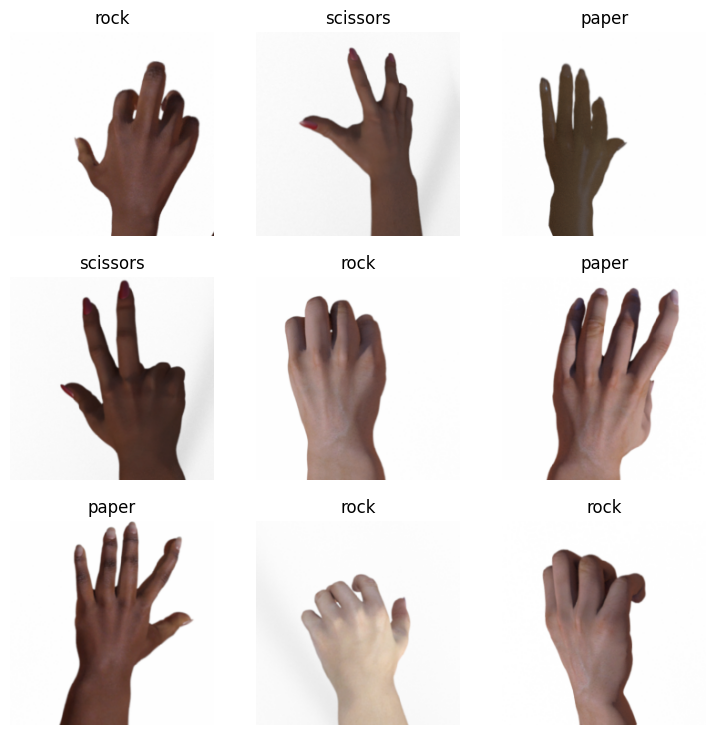

In [70]:
data_train.show_batch()

<a name="neural-network"></a>
## Neural Network

We create our neuralnetwork, starting with RESNET34.

In [71]:
learn = vision_learner(data_train, resnet34, metrics=error_rate)

We find the learning rate.

SuggestedLRs(valley=0.0020892962347716093)

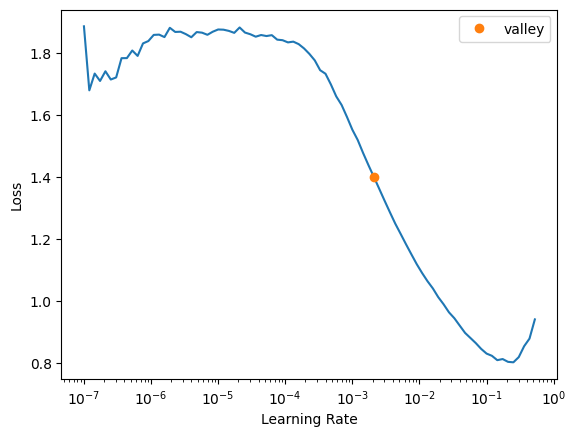

In [72]:
learn.lr_find()

We now can train the network (fit_one_cycle changes LR during training).  

In [73]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.786614,0.019659,0.003968,00:27
1,0.311190,0.002002,0.000000,00:27
2,0.157536,0.000623,0.000000,00:27
3,0.090799,0.000427,0.000000,00:28


We save the model, so we can use it for inference faster.

In [74]:
learn.save('round_1_train')

Path('/content/drive/MyDrive/colab/classificator/train/models/round_1_train.pth')

<a name="inference"></a>
## Inference

We can create a new neural network, same characteristics as previous one

In [75]:
learn2 = vision_learner(data_train, resnet34, metrics=error_rate)

And load it with the saved weights to skip training.

In [76]:
learn2 = learn2.load('round_1_train')

We have utility classes (ClassificationInterpretation) to run interpretation for classifiers.

In [77]:
interp = ClassificationInterpretation.from_learner(learn2)

We can compute the performance of our classifier.

In [78]:
losses, idxs = interp.top_losses()

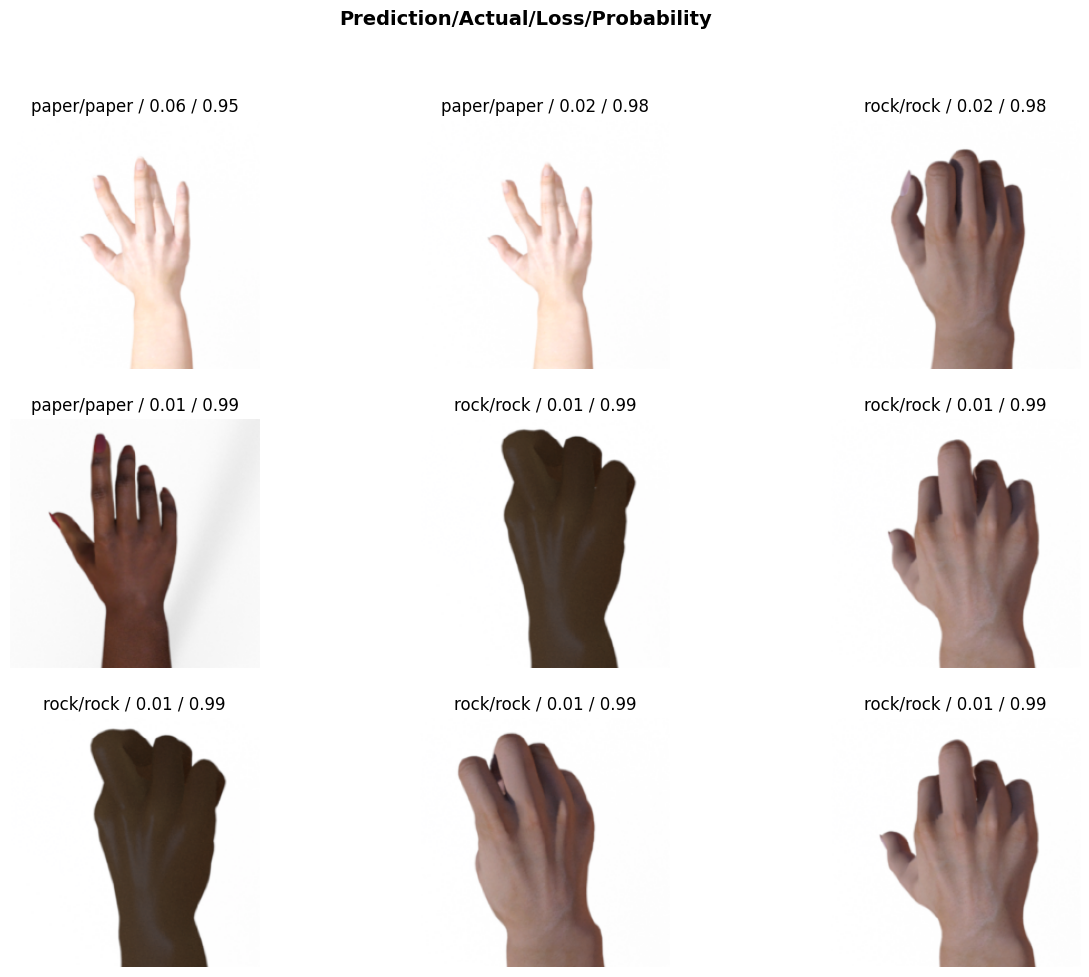

In [79]:
interp.plot_top_losses(9, figsize=(15,11))

<a name="references"></a>

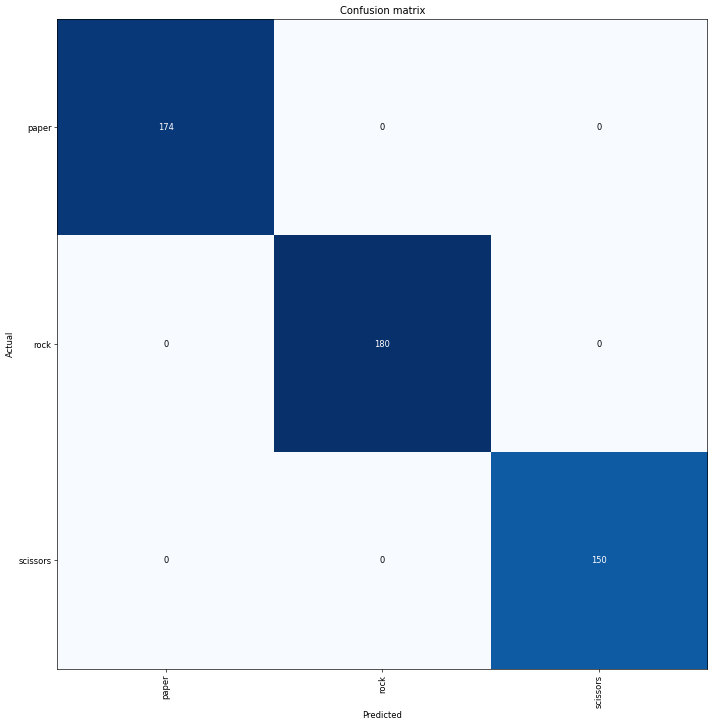

In [80]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

<a name="references"></a>
## References

### Dataset
* Rock Paper Scissors Dataset: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset

### Documentation
* Fast.ai: https://docs.fast.ai/